In [219]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from scipy import stats
import matplotlib.pyplot as plt
import openpyxl
from datetime import date
import ast
from sklearn.metrics import accuracy_score
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from matplotlib import cm

In [295]:
def sin_day(t_date):
    year = t_date // 10000
    month = (t_date // 100) % 100
    day = t_date % 100
    d = date(year,month,day)
    day_num = d.timetuple().tm_yday
    return np.sin(day_num * 2 * np.pi / 365)
def cos_day(t_date):
    year = t_date // 10000
    month = (t_date // 100) % 100
    day = t_date % 100
    d = date(year,month,day)
    day_num = d.timetuple().tm_yday
    return np.cos(day_num * 2 * np.pi / 365)

def get_year(date):
    return int(date/10000)

def new_date(date):
    date =str(date)
    date = date.split('-')
    return int(date[0]+ date[1] + date[2][0:2])

def basic_horizontal_barplot(values,labels,xaxis_label,title,xlim=None,figsize=None):
    cs=["coral","tomato","peachpuff","orange","gold","firebrick","peru","khaki","chocolate"]
    cs=cs*(len(values)//len(cs)+1)
    # The figure
    if figsize==None:
        fig=plt.figure(figsize=(4,3))
    else:
        fig=plt.figure(figsize=figsize,dpi=120)
    ax = fig.add_axes([0,0,1,0.9])
    color=cs[:len(values)]
    ax.barh(range(len(values)),values,color=color)
    ax.set_yticks(range(len(values)))
    ax.set_yticklabels(labels)
    if xlim!=None:
        ax.set_xlim(xlim)
    plt.suptitle(title)
    ax.set_xlabel(xaxis_label)
    plt.show()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
def cond(subset, A,B):
    if subset == 'All':
        return True
    if subset == 'Favorites':
        return A<B
    else:
        return B<A



# Load and preprocessing data

In [101]:
atp = pd.read_csv("atp.csv")
atp = atp.drop(['target'], axis = 1)[3000:].reset_index(drop=True)
atp = atp.iloc[:-10000]

df_odds = pd.concat( 
    [ pd.read_excel( 'result_odds/20{}.xls'.format(i) , na_values = ' ')
     for i in ['00','01','02','03','04','05','06','07','08','09','10','11','12'] ]+
     [ pd.read_excel( 'result_odds/2013.xlsx' , na_values = ' ') ,pd.read_excel( 'result_odds/2014.xlsx' , na_values = ' ') ],
     ignore_index=True)
df_odds.fillna(value=0.0)
df_odds = df_odds.loc[df_odds['Tournament']!='Masters Cup']
df_odds = df_odds.loc[df_odds['Comment']== 'Completed']

df_odds['Date']=df_odds['Date'].apply(new_date)    
df_odds['year'] = df_odds['Date'].apply(get_year)
df_odds['sin_day'] = df_odds['Date'].apply(sin_day)
df_odds['cos_day'] = df_odds['Date'].apply(cos_day)

for ind in tqdm(df_odds.index):
    df_odds.at[ind,'Date'] = min(df_odds.loc[(df_odds['Tournament']==df_odds.at[ind,'Tournament']) & 
                                (df_odds['year']== df_odds.at[ind,'year'])]['Date'])

    
    
SET = []
for ind in tqdm(atp.index):
    SET.append((atp.at[ind,'year'],atp.at[ind,'rank_points_0'],atp.at[ind,'rank_points_1'],atp.at[ind,'rank_0'],atp.at[ind,'rank_1']))
    SET.append((atp.at[ind,'year'],atp.at[ind,'rank_points_1'],atp.at[ind,'rank_points_0'],atp.at[ind,'rank_1'],atp.at[ind,'rank_0']))
    
for ind in tqdm(df_odds.index):    
    if(df_odds.at[ind,'year'],df_odds.at[ind,'WPts'],df_odds.at[ind,'LPts'],df_odds.at[ind,'WRank'],df_odds.at[ind,'LRank']) in SET:
        df_odds.at[ind,'in_atp'] = 1
    else:
        df_odds.at[ind,'in_atp'] = 0
        
df_odds=df_odds.loc[df_odds['in_atp']==1]
df_odds=df_odds[len(df_odds)-4800: len(df_odds)]

       wins_game_semester_level1_0  wins_game_semester_level2_0  \
0                                0                           24   
1                               18                          110   
2                                0                           22   
3                                0                            0   
4                               26                           64   
...                            ...                          ...   
38706                            0                            0   
38707                            0                           22   
38708                            0                            0   
38709                            0                            0   
38710                            0                           36   

       wins_game_semester_level3_0  wins_game_year_level1_0  \
0                               86                        0   
1                              135                       32   
2     

# Bookmakers on test data

In [351]:
B365 = df_odds.loc[df_odds['B365L']>=df_odds['B365W']].shape[0] / df_odds.loc[df_odds['B365L']>0.0].shape[0]
PS = df_odds.loc[df_odds['PSL']>=df_odds['PSW']].shape[0] / df_odds.loc[df_odds['PSL']>0.0].shape[0]
print(B365,PS)

print(np.mean(df_odds['B365W']),
np.mean(df_odds['B365L']),
np.mean(df_odds['PSW']),
np.mean(df_odds['PSL']))

0.7300626304801671 0.7243616575973211
1.7978576802507837 4.258767014613778 1.8874236082042697 4.749451653411469


In [241]:
file_1 = open("Pred_result.txt","r")
load = file_1 .read()
pred = []
for x in load:
    if x== '[':
        pred.append([])
    if x=='0' or x=='1':
        pred[len(pred)-1].append(int(x))
file_2 = open("True_result.txt","r")
load = file_2.read()
RES = []
for x in z_2:
    if x=='0' or x=='1':
        RES.append(int(x))
Class = []
RES = RES[len(RES)-4800:len(RES)]
for i in range(39,51):
    Class.append(accuracy_score(pred[i], RES))

In [242]:
Class.sort(reverse=True)
StackModelPred = pred[49]
QDAModelPred = pred[48]
XGBoostModelPred = pred[43]

# Prediction on example test set

We have to think about a few the best our classifier(maybe not the best predictior will bring the greatest profit)

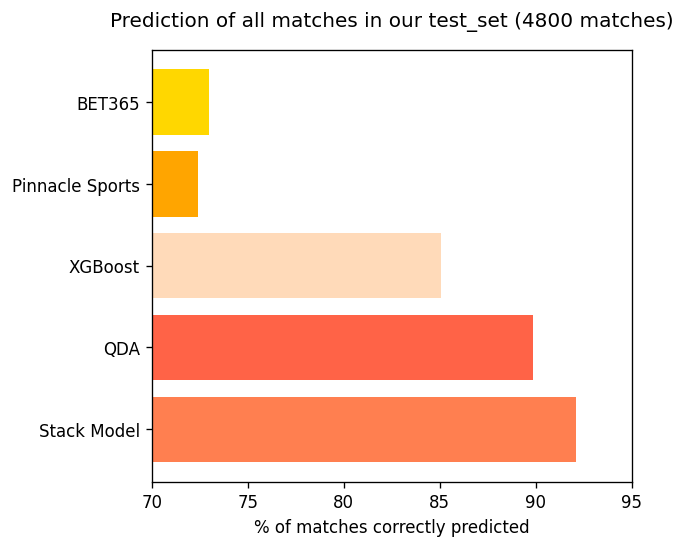

In [258]:
labels=["Stack Model","QDA",
        "XGBoost","Pinnacle Sports",
        "BET365"]
values=[100*Class[0],100*Class[1],100*Class[2],100*PS,100*B365]
xaxis_label="% of matches correctly predicted"
title="Prediction of all matches in our test_set (4800 matches)"
xlim=[70,95]
basic_horizontal_barplot(values,labels,xaxis_label,title,xlim,figsize=(4,4))

ROI -  Return of investment - Measure profit from investment we define like :
$$\frac{(finishCapital -InvestCapital)}  {InvestCapital} $$

 # Naive strategies

- bet for all matches
- the same stake for all (100 PLN)
- We don't have money limit

In [188]:
Capitals = []
for Pred in [StackModelPred, QDAModelPred, XGBoostModelPred]:
    for bookmakers in ['B365','PS']:
        Capital = []
        counter = 0
        courses = list(df_odds['{}W'.format(bookmakers)])
        for i in range(0,4800):
            if not np.isnan(courses[i]):
                if Pred[i]==RES[i]:
                    counter = counter + 100* courses[i]
                    Capital.append(counter)
                else:
                    counter = counter - 100
                    Capital.append(counter)
            else:
                Capital.append(counter)
        counter = counter - 100
        Capitals.append(Capital)

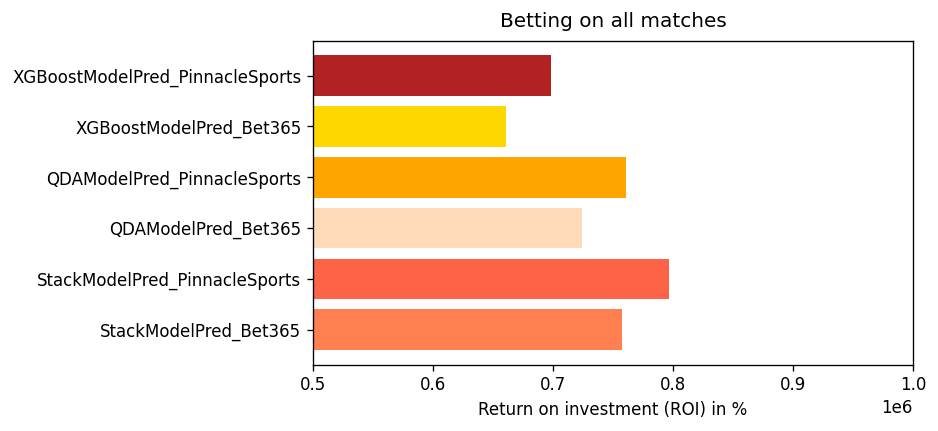

In [189]:
values=[Result[len(Result)-1] for Result in Capitals]
labels=[ 'StackModelPred_Bet365', 'StackModelPred_PinnacleSports', 'QDAModelPred_Bet365', 'QDAModelPred_PinnacleSports'
        ,'XGBoostModelPred_Bet365', 'XGBoostModelPred_PinnacleSports']
xaxis_label="Return on investment (ROI) in %"
title="Betting on all matches"
basic_horizontal_barplot(values,labels,xaxis_label,title,[500000,1000000],(5,3))


Pinnacle Sports guarantee higher profit

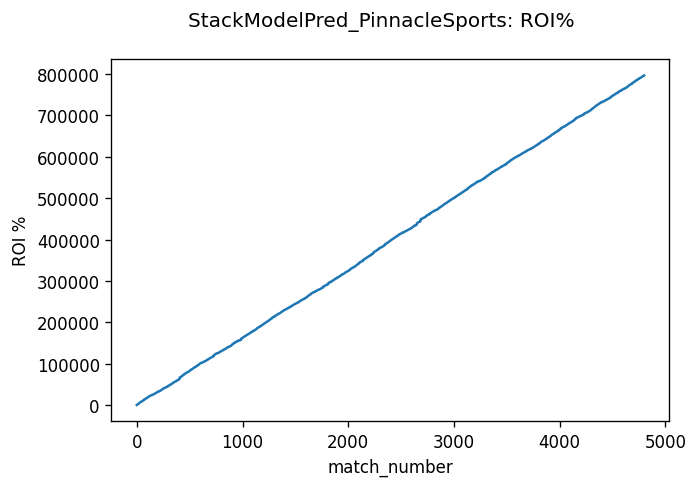

In [190]:
fig=plt.figure(figsize=(6,4),dpi=120)
plt.ylabel('ROI %')
plt.xlabel('match_number')
plt.suptitle('StackModelPred_PinnacleSports: ROI%')
plt.plot(range(0,4800),Capitals[1])

# Subset Selection

- bet for subset of all mathes
- the same stake for all (100 PLN)
- We don't have money limit


## Yield
$$ Yield = \frac{ \sum_{i}^{n} g_i}{\sum_{i}^{n} r_i} $$
where i is number of bet, $g_i$ is gain in i bet and $r_i$ is rate in i bet

In [333]:
def Naive(subset,Pred,odds_w,odds_l,Y,size):
    counter = 0
    counter_bet = 0
    for i in range(0,size):
        if not np.isnan(odds_w[i]):
            if cond(subset,odds_w[i],odds_l[i]):
                counter_bet = counter_bet + 1
                if Pred[i]==Y[i]:
                    counter = counter + 100* (odds_w[i] - 1.0)
                else:
                    counter = counter - 100
    return round(counter / (counter_bet * 100),5)

## Bet on favorites



In [363]:
Yield_1 = Naive("Favorites",StackModelPred,list(df_odds["PSW"]),list(df_odds["PSL"]),RES,4800)
print("Yield score for Naive strategy and Favorites subset:", Yield_1)

Yield score for Naive strategy and Favorites subset: 0.26551


## Bet on underdogs

In [356]:
Yield_2 = Naive("Underdogs",StackModelPred,list(df_odds["PSW"]),list(df_odds["PSL"]),RES,4800)
print("Yield score for Naive strategy and Underdogs subset:", Yield_2)

Yield score for Naive strategy and Underdogs subset: 1.99976


## All matches

In [357]:
Yield_3 = Naive("All",StackModelPred,list(df_odds["PSW"]),list(df_odds["PSL"]),RES,4800)
print("Yield score for Naive strategy and All subset:", Yield_3)

Yield score for Naive strategy and All subset: 0.74602


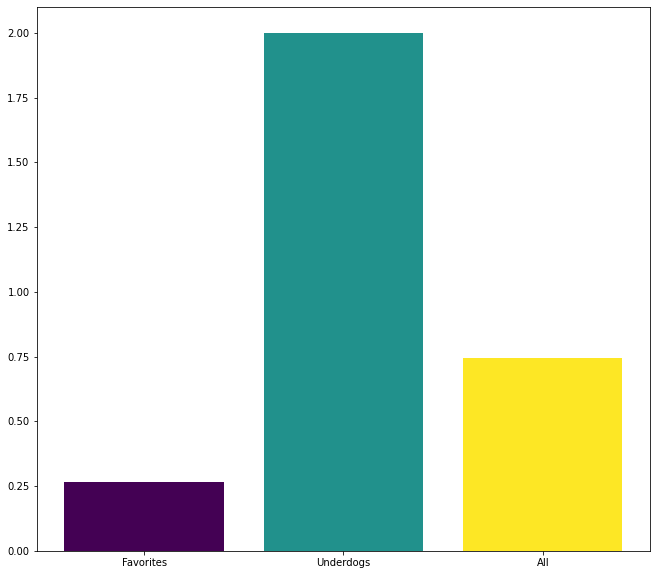

In [337]:
v = cm.get_cmap('viridis')
colors = v(np.linspace(0, 1, 3))
fig, ax = plt.subplots(figsize=(11, 10))
plt.bar(np.arange(3), [Yield_1,Yield_2,Yield_3], color = colors)
plt.xticks(np.arange(3), ('Favorites', 'Underdogs', 'All'))
plt.show()


We have intuitions that higher odds are better

# Martingale (betting system)

- bet for underdogs
- stake(100 PLN) or if we have lose streak we want to make money back
- We don't have money limit

In [367]:
def Martingale(subset,Pred,odds_w,odds_l,Y,size):
    counter = 0
    counter_bet = 0
    lose_streak = 0
    lost_money = 100
    for i in range(0,size):
        if not np.isnan(odds_w[i]):
            if cond(subset,odds_w[i],odds_l[i]):
                if Pred[i] == Y[i]:
                    if lose_streak == 0:
                        counter = counter + 100* (odds_w[i] - 1.0)
                        counter_bet = counter_bet + 100
                    else:
                        counter = counter + lost_money
                        counter_bet = counter_bet + lost_money
                    lost_money = 100
                else:
                    counter = counter - lost_money / (odds_l[i] - 1.0)
                    lost_money = lost_money + (lost_money / (odds_l[i] - 1.0) )
                    counter_bet = counter_bet + (lost_money / (odds_l[i] - 1.0) )
                    lose_streak = lose_streak + 1
    return round(counter / (counter_bet),5)
                

## Favorites

In [371]:
Yield_4 = Martingale("Favorites",StackModelPred,list(df_odds["PSW"]),list(df_odds["PSL"]),RES,4800)
print("Yield score for Martingale strategy and Favorites subset:", Yield_4)

Yield score for Martingale strategy and Favorites subset: 0.90114


## Underdogs

In [372]:
Yield_5 = Martingale("Underdogs",StackModelPred,list(df_odds["PSW"]),list(df_odds["PSL"]),RES,4800)
print("Yield score for Martingale strategy and Underdogs subset:", Yield_5)

Yield score for Martingale strategy and Underdogs subset: 0.50577


## All Matches

In [373]:
Yield_6 = Martingale("All",StackModelPred,list(df_odds["PSW"]),list(df_odds["PSL"]),RES,4800)
print("Yield score for Martingale strategy and All subset:", Yield_6)

Yield score for Martingale strategy and All subset: 0.73537


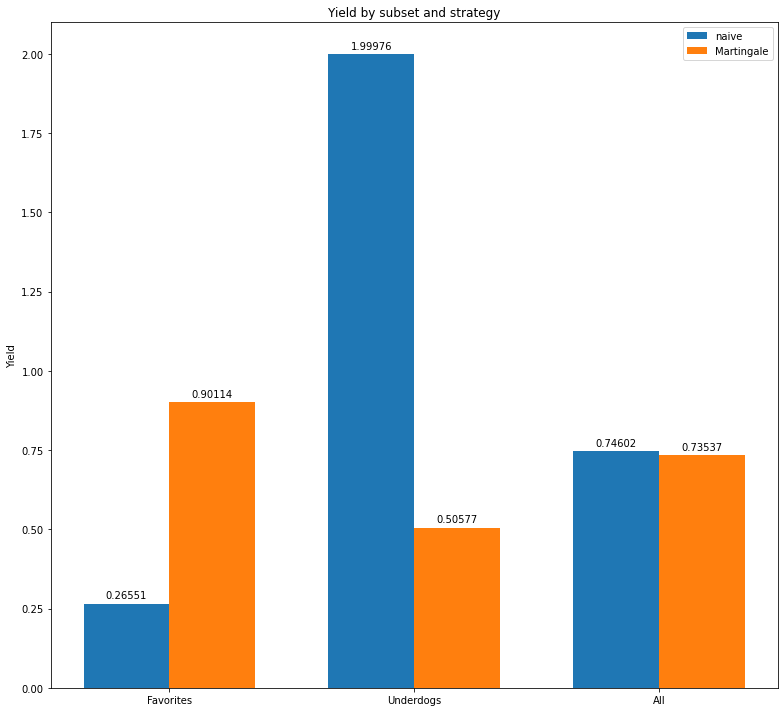

In [342]:
labels = ['Favorites','Underdogs','All']
naive = [Yield_1,Yield_2,Yield_3]
Martingale = [Yield_4,Yield_5,Yield_6]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(11, 10))
rects1 = ax.bar(x - width/2, naive, width, label='naive')
rects2 = ax.bar(x + width/2, Martingale, width, label='Martingale')

ax.set_ylabel('Yield')
ax.set_title('Yield by subset and strategy')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

# Kelly criterion

$$ K = \frac{bp-q}{b} $$
where b is multiple of your stake you can win from the proposed wager, p is the probability of the proposed wager winning, $q = 1-p$

In [347]:
def Kelly(subset,Pred,odds_w,odds_l,Y,size,max_r,p,q):
    counter = 100
    counter_bet = 0
    for i in range(0,size):
        if not np.isnan(odds_w[i]):
            if cond(subset,odds_w[i],odds_l[i]):
                if Pred[i]==Y[i]:
                    K = (p* odds_w[i] - q)/ odds_w[i]
                    counter = counter + min((K*counter),max_r) * (odds_w[i] - 1.0)
                    counter_bet = counter_bet + min((K*counter),max_r)
                else:
                    K = (p* odds_l[i] - q)/ odds_l[i]
                    counter = counter - min((K*counter),max_r)
                    counter_bet = counter_bet + min((K*counter),max_r)
    if counter_bet > 0:
        Yield_K = round(counter / (counter_bet),5)
    else:
        Yield_K = 0
    return Yield_K

In [374]:
Yield_K = Kelly("Underdogs",StackModelPred,list(df_odds["PSW"]),list(df_odds["PSL"]),RES,4800,100000,0.92,0.08)
print("Yield score for Kelly strategy and Underdogs subset:", Yield_K)

Yield score for Kelly strategy and Underdogs subset: 2.00054
